# Employee Promotion Prediction Analysis\n
## Supervised Learning Classification Project

## 1. Initial Setup and Data Loading

In [8]:
!pip install plotext rich seaborn scikit-learn matplotlib pandas numpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# Import necessary libraries\n
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, roc_curve, auc, 
                            classification_report, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import time
import warnings
import plotext as pltx
from rich.console import Console

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
console = Console()

# Load dataset
df = pd.read_csv('employee_promotion_updated.csv')

## 2. Exploratory Data Analysis (EDA)

### Target Variable Distribution

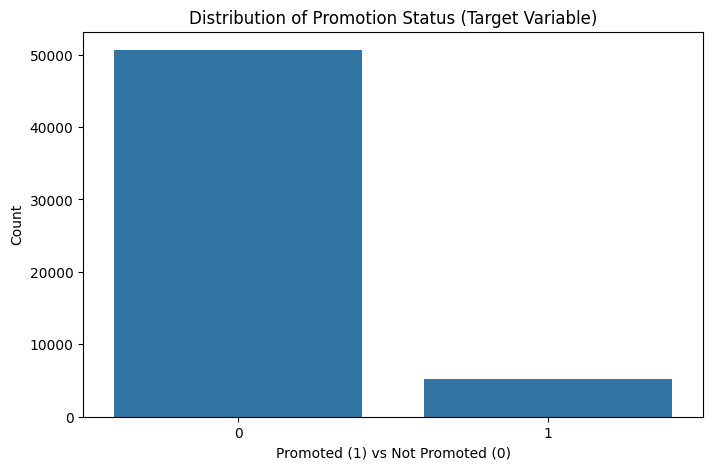

========== Promotion percentage ==========

Promoted: 9.29%
Not Promoted: 90.71%



In [10]:
# Plot promotion status distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='is_promoted', data=df)
plt.title('Distribution of Promotion Status (Target Variable)')
plt.xlabel('Promoted (1) vs Not Promoted (0)')
plt.ylabel('Count')
plt.show()

# Calculate promotion percentages
promoted_percentage = df['is_promoted'].value_counts(normalize=True) * 100
console.print(f"\n========== Promotion percentage ==========", style="bold blue")
print(f"Promoted: {promoted_percentage[1]:.2f}%")
print(f"Not Promoted: {promoted_percentage[0]:.2f}%\n")

### Numerical Features Analysis

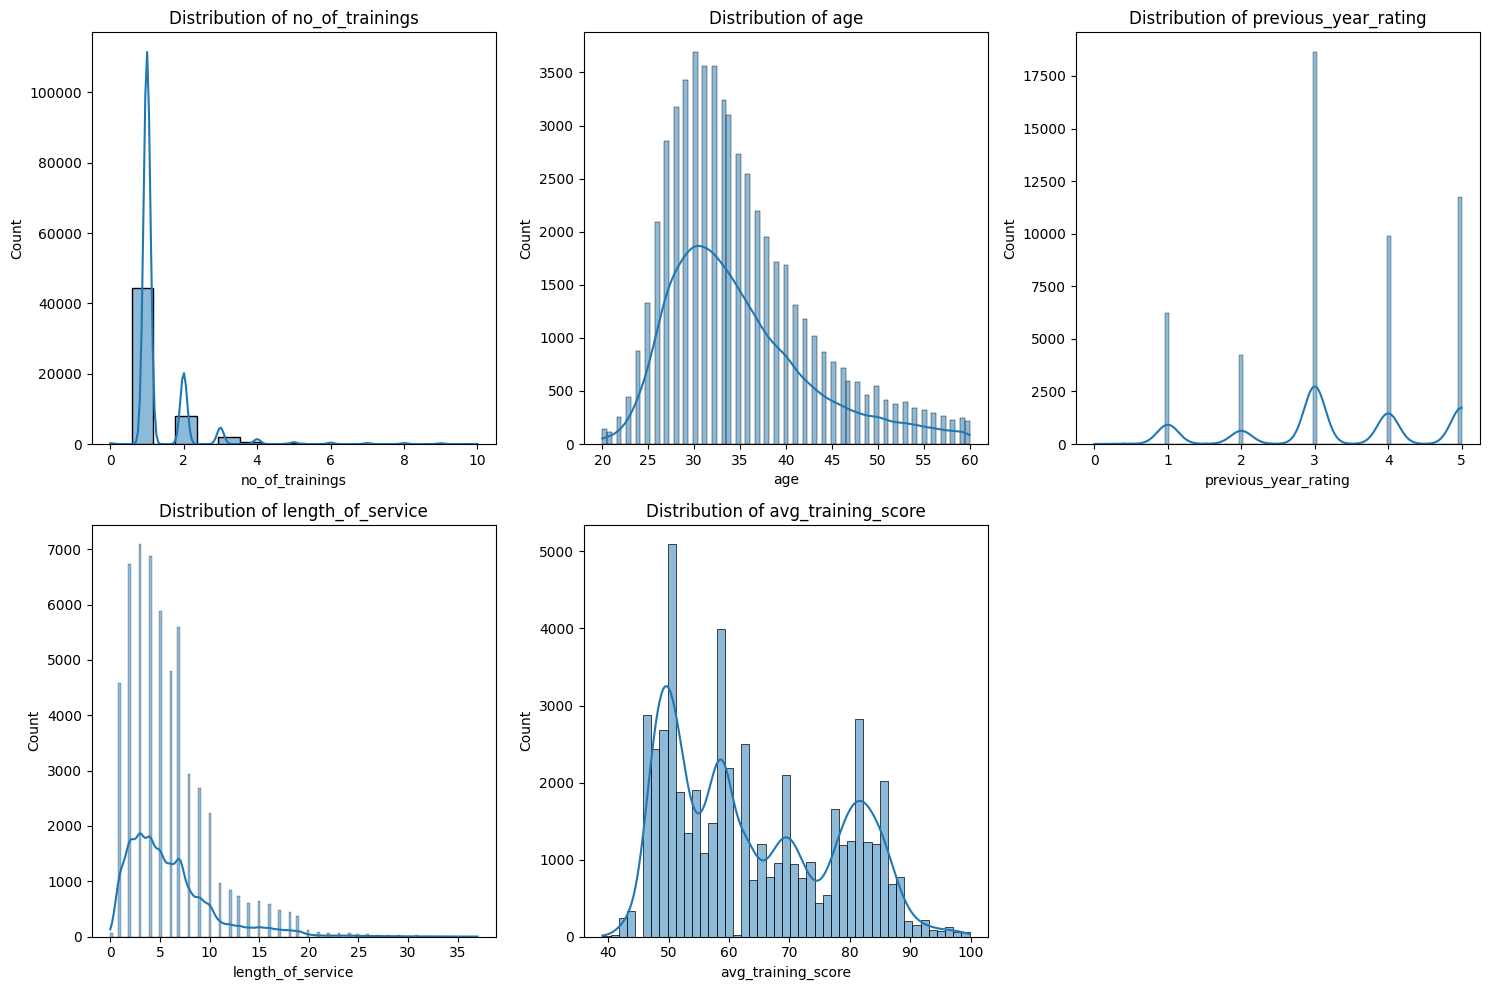

In [11]:
numerical_cols = ['no_of_trainings', 'age', 'previous_year_rating', 
                 'length_of_service', 'avg_training_score']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Categorical Features Analysis

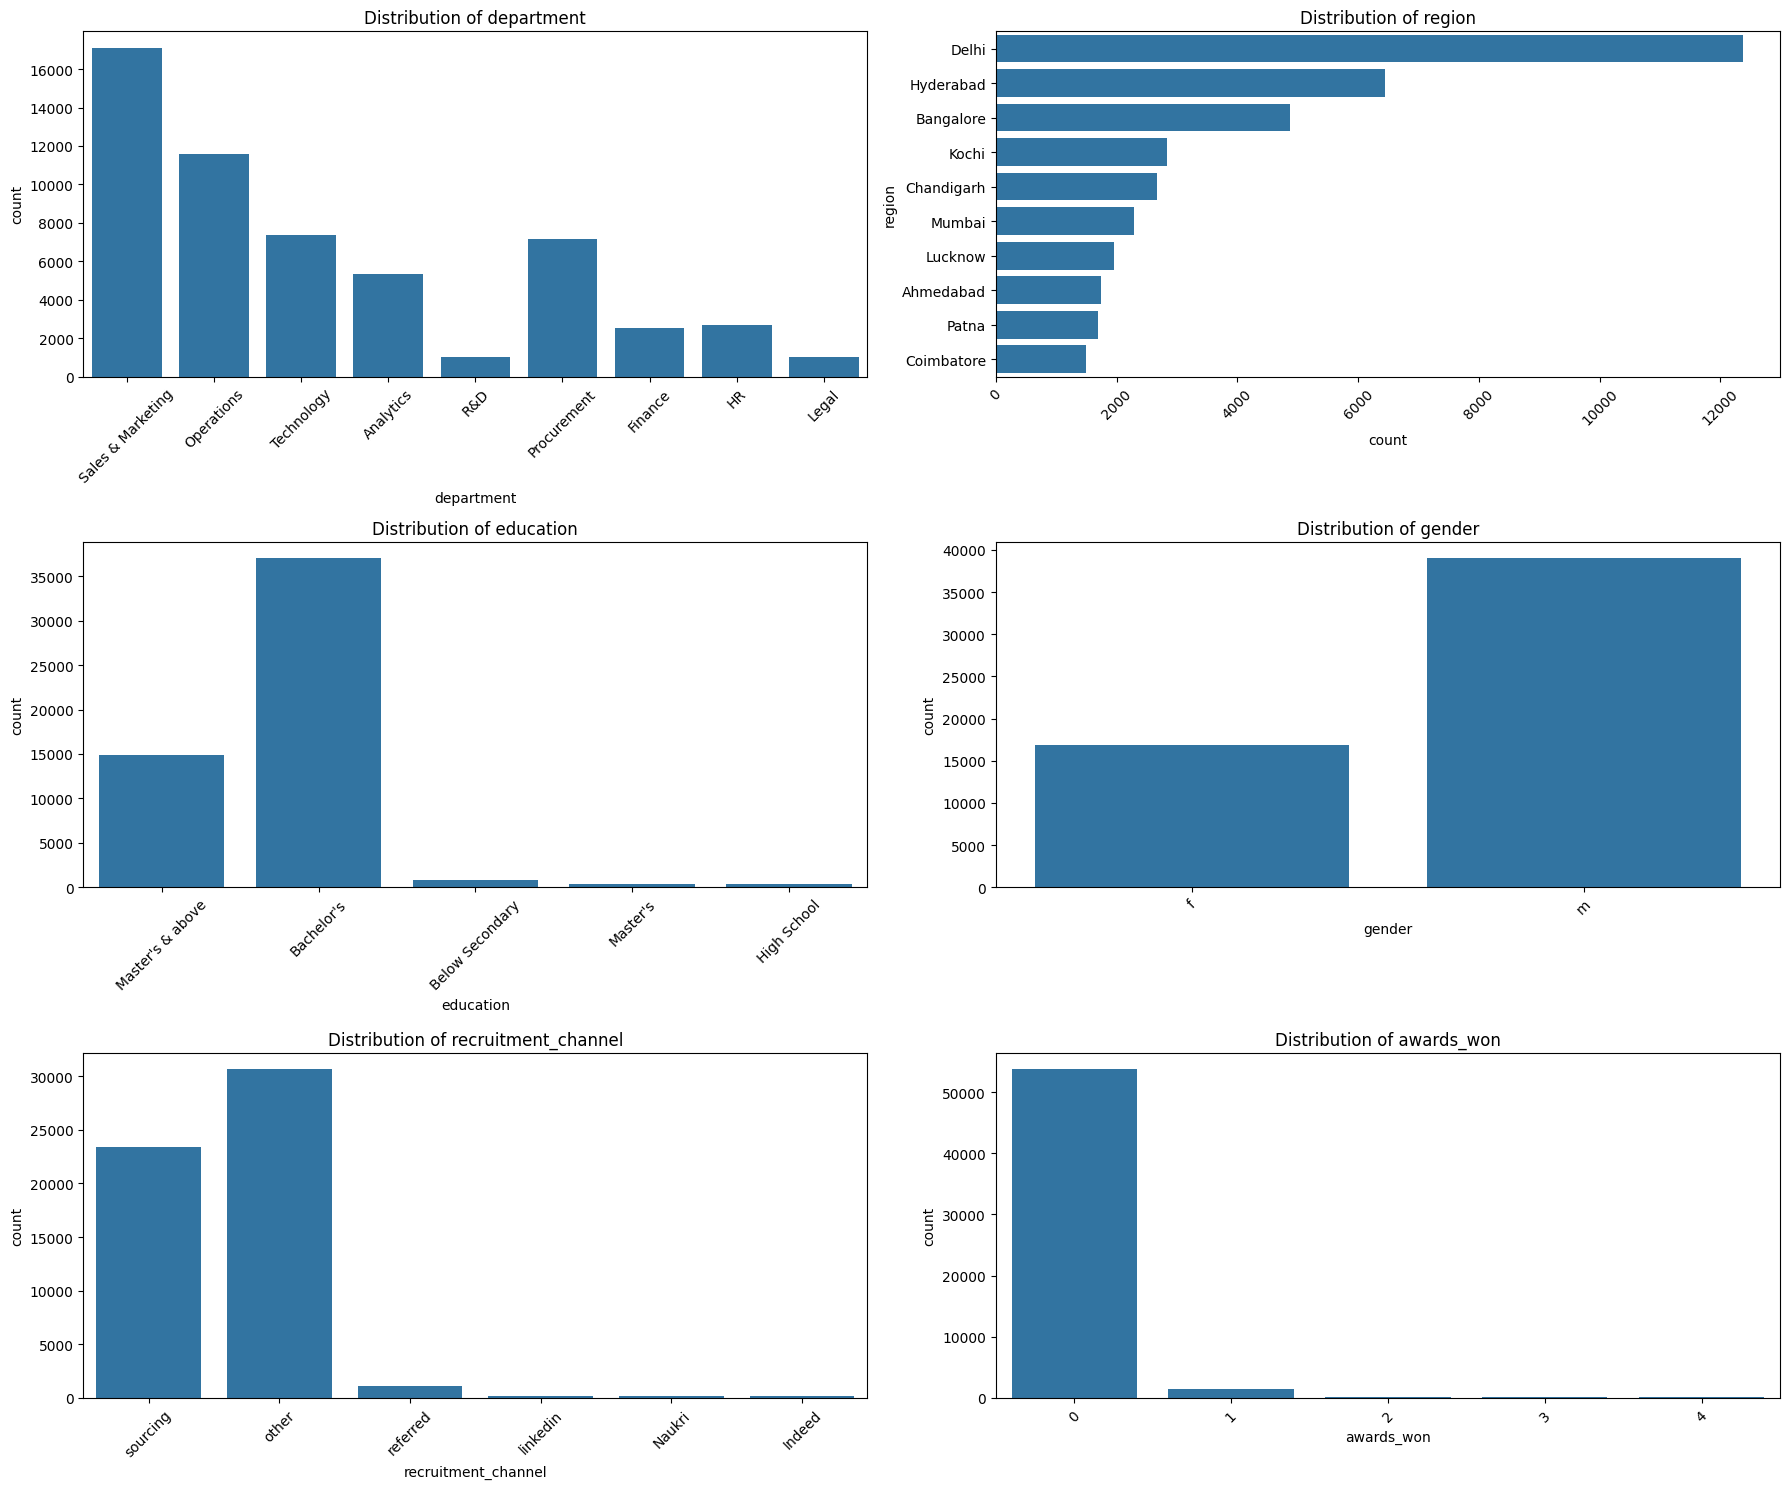

In [12]:
categorical_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'awards_won']

plt.figure(figsize=(18, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    if df[col].nunique() > 10:  
        sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10])
    else:
        sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Correlation Analysis

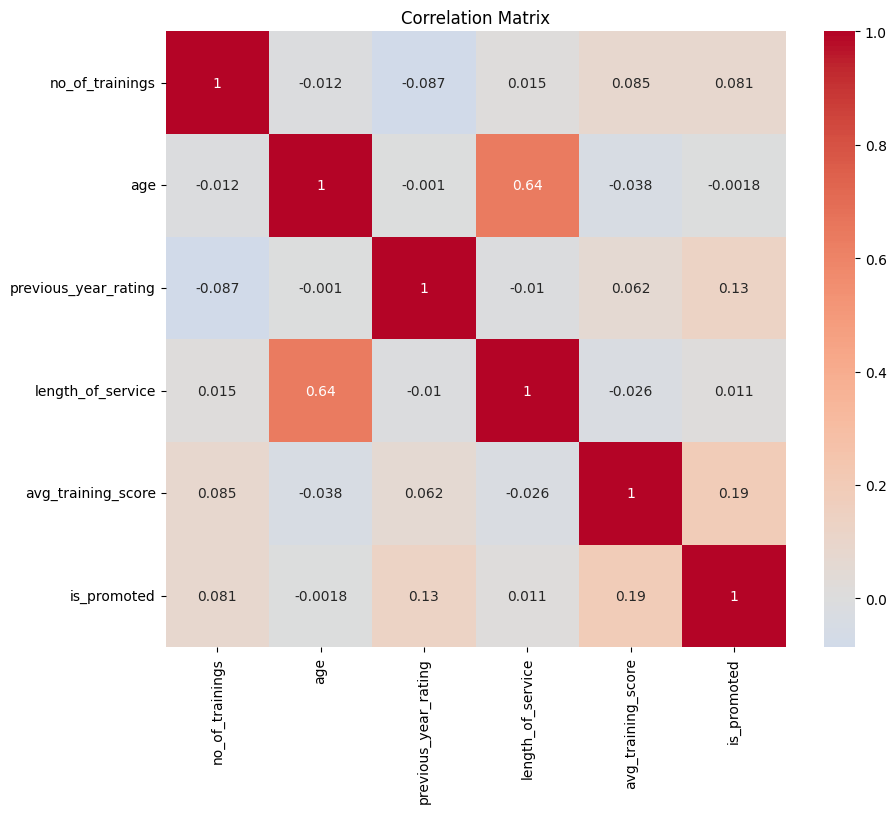

In [13]:
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_cols + ['is_promoted']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## 3. Data Preprocessing

In [14]:
# Prepare features and target
df = df.drop('employee_id', axis=1)
X = df.drop('is_promoted', axis=1)
y = df['is_promoted']

# Split data (stratify due to class imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## 4. Model Training and Evaluation

========== Decision Tree ==========

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10126
           1       0.37      0.42      0.39      1036

    accuracy                           0.88     11162
   macro avg       0.65      0.67      0.66     11162
weighted avg       0.89      0.88      0.88     11162



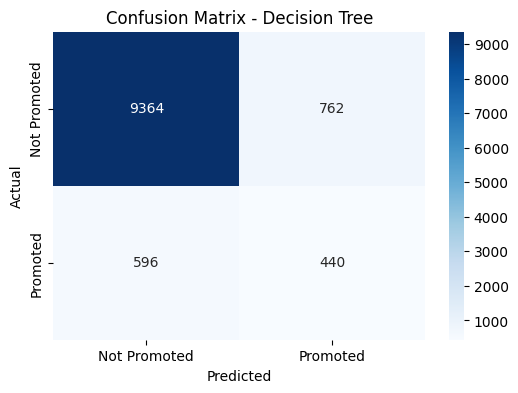

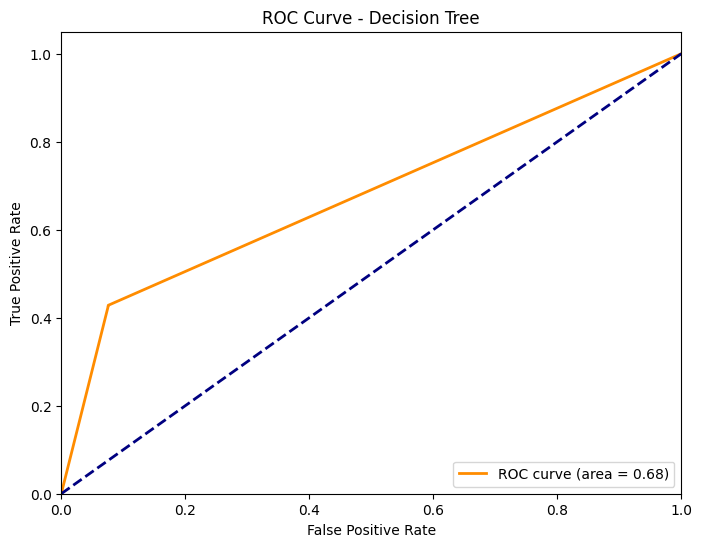

========== k-NN ==========

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     10126
           1       0.60      0.14      0.23      1036

    accuracy                           0.91     11162
   macro avg       0.76      0.57      0.59     11162
weighted avg       0.89      0.91      0.89     11162



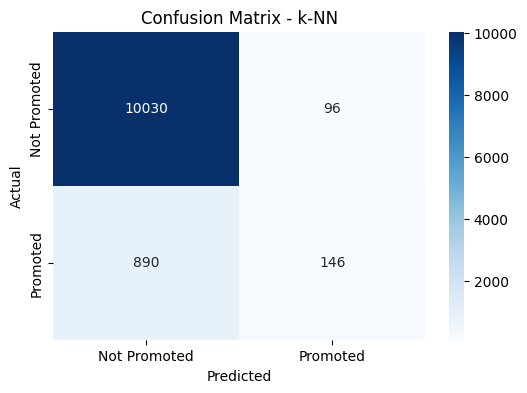

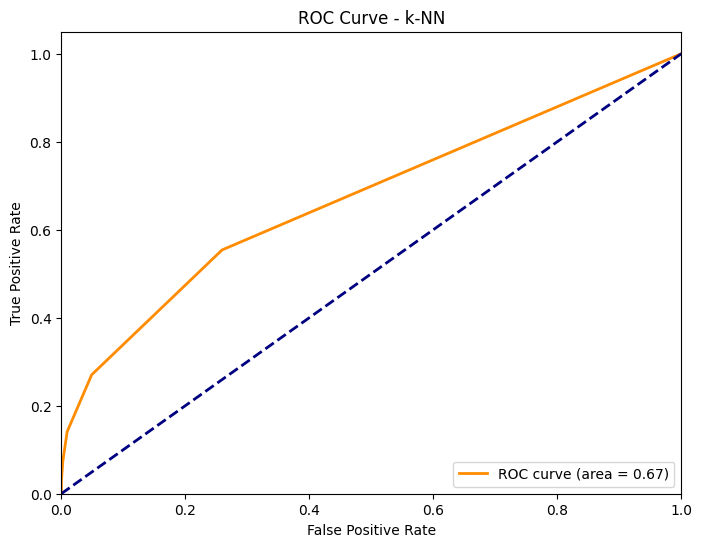

========== Logistic Regression ==========

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     10126
           1       0.80      0.22      0.35      1036

    accuracy                           0.92     11162
   macro avg       0.86      0.61      0.65     11162
weighted avg       0.91      0.92      0.90     11162



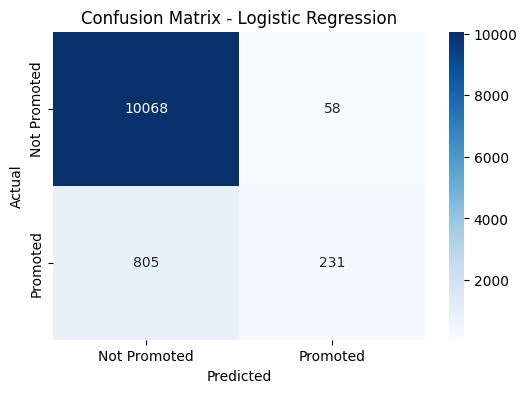

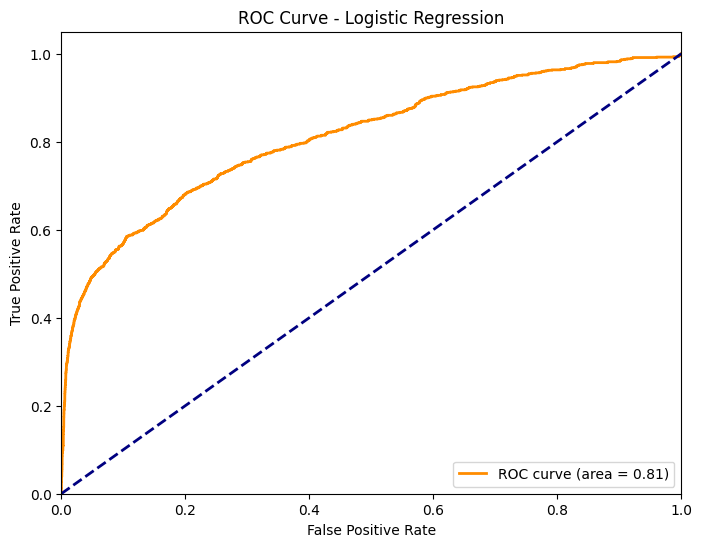

========== Model Comparison ==========

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0        Decision Tree  0.878337   0.366057  0.424710  0.393208  0.676166   
1                 k-NN  0.911665   0.603306  0.140927  0.228482  0.671205   
2  Logistic Regression  0.922684   0.799308  0.222973  0.348679  0.811174   

   Training Time (s)  Prediction Time (s)  
0           1.403206             0.029980  
1           0.066104            24.051206  
2           0.278233             0.047000  


In [15]:
# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'k-NN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Results storage
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
    'Training Time (s)': [],
    'Prediction Time (s)': []
}

# Model training and evaluation loop
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Training
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Prediction
    start_time = time.time()
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else [0]*len(y_test)
    predict_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if hasattr(model, 'predict_proba') else 0
    
    # Store results
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)
    results['ROC AUC'].append(roc_auc)
    results['Training Time (s)'].append(train_time)
    results['Prediction Time (s)'].append(predict_time)
    
    # Print classification report
    console.print(f"\n========== {name} ==========", style="bold blue")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Promoted', 'Promoted'],
                yticklabels=['Not Promoted', 'Promoted'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Plot ROC curve if model supports probability estimates
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results)
console.print("\n========== Model Comparison ==========", style="bold blue")
print(results_df)

## 5. Results Visualization

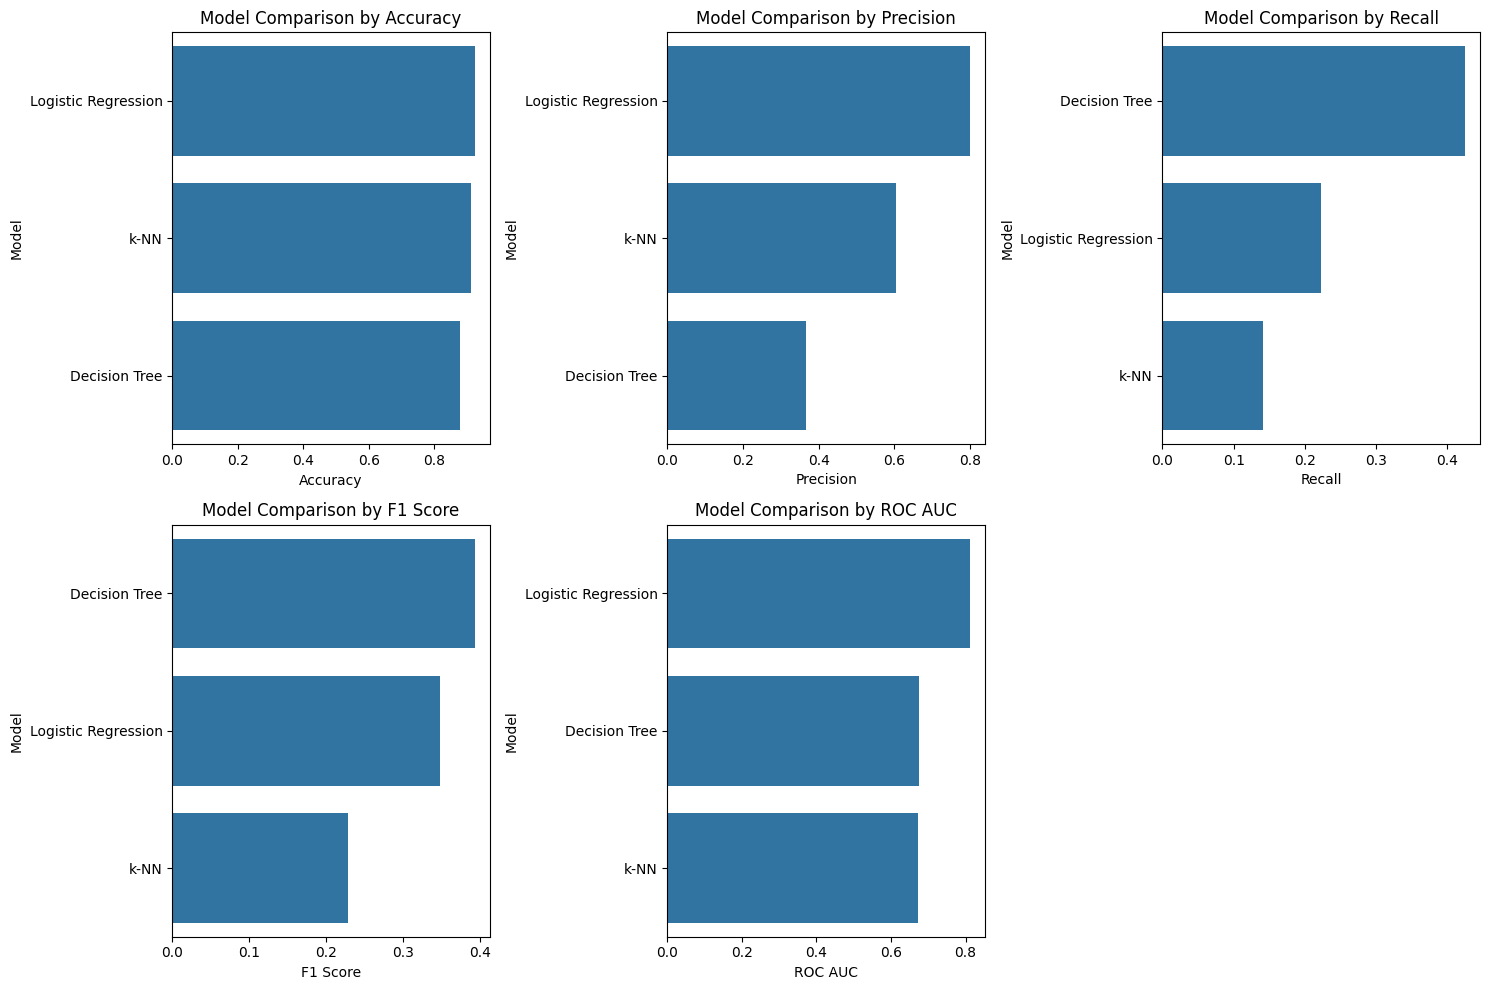

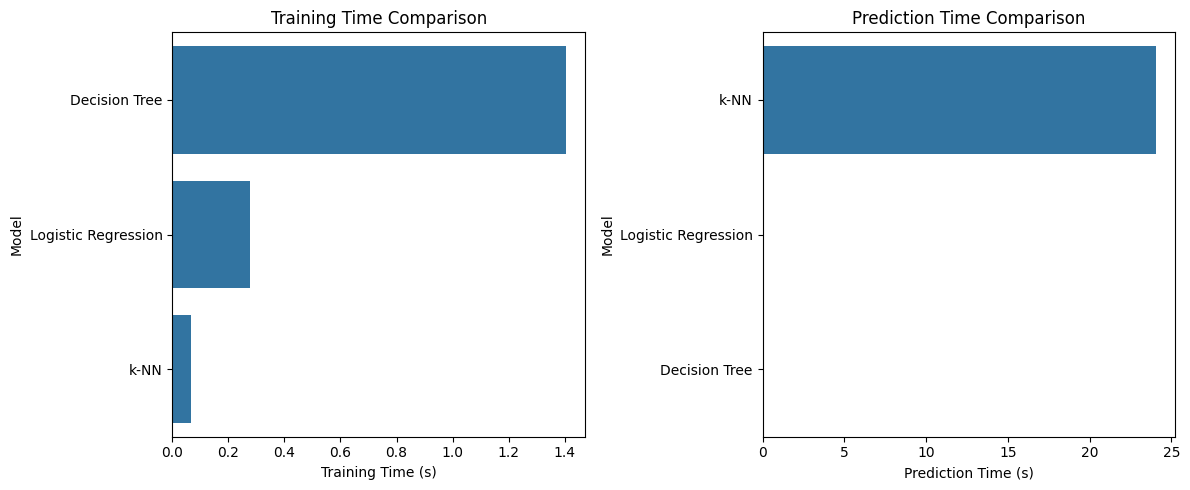

========== Some Comparison Graphics ==========

                             Model Comparison - Accuracy                        
    ┌──────────────────────────────────────────────────────────────────────────┐
0.92┤                          ██████████████████████    ██████████████████████│
    │██████████████████████    ██████████████████████    ██████████████████████│
0.77┤██████████████████████    ██████████████████████    ██████████████████████│
    │██████████████████████    ██████████████████████    ██████████████████████│
    │██████████████████████    ██████████████████████    ██████████████████████│
0.62┤██████████████████████    ██████████████████████    ██████████████████████│
    │██████████████████████    ██████████████████████    ██████████████████████│
0.46┤██████████████████████    ██████████████████████    ██████████████████████│
    │██████████████████████    ██████████████████████    ██████████████████████│
0.31┤██████████████████████    ██████████████████████    ██████████████████████│
    │██████████████████████ 

In [16]:
# Model comparison by metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=metric, y='Model', data=results_df.sort_values(by=metric, ascending=False))
    plt.title(f'Model Comparison by {metric}')
plt.tight_layout()
plt.show()

# Training and prediction time comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Training Time (s)', y='Model', data=results_df.sort_values(by='Training Time (s)', ascending=False))
plt.title('Training Time Comparison')

plt.subplot(1, 2, 2)
sns.barplot(x='Prediction Time (s)', y='Model', data=results_df.sort_values(by='Prediction Time (s)', ascending=False))
plt.title('Prediction Time Comparison')
plt.tight_layout()
plt.show()

# Text-based visualizations
console.print("\n========== Some Comparison Graphics ==========", style="bold blue")
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

for metric in metrics_to_plot:
    pltx.clear_figure()
    pltx.title(f"Model Comparison - {metric}")
    pltx.bar(results_df['Model'].tolist(), results_df[metric].tolist())
    pltx.xlabel("Models")
    pltx.ylabel(metric)
    pltx.plotsize(100, 20)
    pltx.show()
    print("\n\n")